In [3]:
import os
import sys
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt 

s_path = os.path.dirname(os.path.realpath(__file__))
sys.path.append(s_path)

pd.set_option('display.max_columns',100)
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import tm_teoriaMvto_base_prep as base_prep
import tm_teoriaMvto_ft_eng as ft_eng
from make_pickles import PipeX

# configuration for labeling and loading
path_files = os.path.join(s_path, 'historical_files')

# base prep control
EXPORT_X = True
EXPORT_Y = True

# params labeling
s_prefix = 'ft_'
s_lbl_type = 'regression'
f_th = 0.3
b_dist = True
b_percent = True
b_custom = False

In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Desktop\Anaconda3\envs\n

In [4]:
if EXPORT_X:
  # df_data = base_prep.import_sampling(path_files= os.path.join(path_files, 'FeaturesFiles'), 
  #   prefix_files= s_prefix)
  df_data = pd.read_csv(os.path.join(path_files, 'FeaturesFiles', 'AllFiles.csv')) #, index_col= 0, nrows=100000
  df_data.drop(columns='Unnamed: 0', inplace=True)

  # create new features before extracting samples - using full data needed by lag features
  df_data = ft_eng.BasicFeatures().transform(X=df_data)

In [5]:
if EXPORT_Y:
  col_label = [ 'date_trd', 'update', 'time', 'trd_id', # IDX
    'side', 'first_price', 'id_run', 's_run', 
    'max_run', 'flag_d', 'id_p', 'seq', 
    'chg_max', 'chg_max_mp', 'freq', 'model']

  # specify df_data = None (default) to load pickle from s_path + 'y_prep_data.pkl'
  df_y = df_data[col_label].copy()
  label_type= s_lbl_type
  b_dist_to_high= b_dist
  prefix_files = s_prefix
  th_label_y1=f_th
  b_percent_freq=b_percent
  b_custom_dir=b_custom

  th = int(th_label_y1) if not b_percent_freq else (th_label_y1 * df_y['freq'])

  # variables needed for label
  df_y['run_high'] = df_y.groupby(['date_trd','id_run'])['max_run'].transform('last')

  if b_custom_dir:
    if b_dist_to_high:
      run_sz = th * 2
    else:
      run_sz = th
    df_y['d_run'] = df_y['run_high'].abs() >= run_sz
  else:
    df_y['d_run'] = df_y.groupby(['date_trd','id_run'])['flag_d'].transform('last')

  m_same_p = ((df_y['s_run'] != 0) & ((df_y['chg_max'] == df_y['max_run']) |
   (df_y['chg_max_mp'] == - df_y['max_run'])))
  df_y.loc[m_same_p, 'id_first_p'] = df_y.loc[m_same_p, 'id_p']

  m_first_p = (df_y['id_run'] > df_y['id_run'].shift()) & pd.isna(df_y['id_first_p'])
  df_y.loc[m_first_p, 'id_first_p'] = df_y.loc[m_first_p, 'id_p']-2

  df_first_p = df_y.loc[pd.notna(df_y['id_first_p']), ['date_trd', 'id_first_p', 'run_high']]
  df_first_p.set_index(['date_trd', 'id_first_p'], inplace= True)
  
  if df_first_p.index.duplicated().any():
    df_first_p = df_first_p.loc[~df_first_p.index.duplicated(keep='first')]

  # try to drop to prevent error in case of 
  # running multiple times
  try:
    df_y.drop(columns=['run_high_dir'], inplace=True)  
  except KeyError:
    pass

  # add _dir joining from first P of the run
  df_y = df_y.join(df_first_p, on=['date_trd','id_p'], rsuffix='_dir')

In [6]:
df_y['y'] = np.nan

# first: treat ideal start of the run (formal end of previous movement)
# df_y.loc[pd.notna(df_y['run_high_dir']) & pd.notna(df_y['model']), 'y'] = df_y['run_high_dir']
df_y.loc[pd.notna(df_y['run_high_dir']) & pd.notna(df_y['model']) , 'y'] = df_y['run_high_dir'] - df_y['chg_max']

lbl_run_high = pd.isna(df_y['y']) & pd.notna(df_y['model'])
# df_y.loc[lbl_run_high, 'y'] = df_y['run_high']
df_y.loc[lbl_run_high & (df_y['chg_max'].abs() >= df_y['chg_max_mp'].abs()), 'y'] = df_y['run_high'] - df_y['max_run']
df_y.loc[lbl_run_high & (df_y['chg_max'].abs() <  df_y['chg_max_mp'].abs()), 'y'] = df_y['run_high'] - (df_y['max_run'] + df_y['chg_max_mp'] + df_y['chg_max'])

In [7]:
df_s_run = df_y.loc[:,['date_trd', 'id_run', 's_run']].drop_duplicates()
df_s_run['id_run'] = df_s_run['id_run']-1
# df_s_run.loc[df_s_run['id_run']<0,'id_run'] = 0  # remove this row because of duplicates
df_s_run.set_index(['date_trd', 'id_run'], inplace=True)
df_y = df_y.join(df_s_run, on=['date_trd', 'id_run'], rsuffix='_next')
df_y['s_run_next'].fillna(0, inplace=True)

df_y.loc[(df_y['model'].isin(['md_up', 'mi_up', 'mw_up'])) & ((df_y['s_run'] > 0) | (df_y['s_run_next'] == 0)),'id_run_exit'] = df_y['id_run']+1
df_y.loc[(df_y['model'].isin(['md_down', 'mi_down', 'mw_down'])) & ((df_y['s_run'] < 0) | (df_y['s_run_next'] == 0)),'id_run_exit'] = df_y['id_run']+1
df_y.loc[(df_y['model'].isin(['md_up', 'mi_up', 'mw_up'])) & (df_y['s_run'] <= 0) & pd.isna(df_y['id_run_exit']),'id_run_exit'] = df_y['id_run']+2
df_y.loc[(df_y['model'].isin(['md_down', 'mi_down', 'mw_down'])) & (df_y['s_run'] >= 0) & pd.isna(df_y['id_run_exit']),'id_run_exit'] = df_y['id_run']+2
df_y['id_run_exit'].fillna(method='ffill', inplace=True)
df_y['id_run_exit'].fillna(0, inplace=True)
df_y = df_y.astype({'id_run_exit': 'int64'})

df_run = df_y.groupby(['date_trd', 's_run', 'id_run'], as_index=False)['first_price'].first().sort_values('id_run')
df_run.rename(columns={'id_run': 'id_run_exit'}, inplace=True)
df_run_zero = df_run.loc[df_run['s_run'] == 0, ['date_trd', 'id_run_exit', 'first_price']]
df_run_up = df_run.loc[df_run['s_run'] == 1, ['date_trd', 'id_run_exit', 'first_price']]
df_run_down = df_run.loc[df_run['s_run'] == -1, ['date_trd', 'id_run_exit', 'first_price']]

df_y.sort_values(by=['id_run_exit'], inplace=True)  # 'date_trd',
df_y = pd.merge_asof(df_y, df_run_down, by='date_trd', on='id_run_exit', direction='forward', suffixes=('','_down'))
df_y = pd.merge_asof(df_y, df_run_up, by='date_trd', on='id_run_exit', direction='forward', suffixes=('','_up'))
df_y = pd.merge_asof(df_y, df_run_zero, by='date_trd', on='id_run_exit', direction='forward', suffixes=('','_zero'))

# df_y.sort_values(['date_trd', 'update', 'time','trd_id'], inplace=True)
df_y.loc[(df_y['model'].isin(['md_up', 'mi_up', 'mw_up'])) & (df_y['s_run_next'] != 0), 'exit_price'] = df_y['first_price_down']
df_y.loc[(df_y['model'].isin(['md_down', 'mi_down', 'mw_down'])) & (df_y['s_run_next'] != 0), 'exit_price'] = df_y['first_price_up']
df_y.loc[pd.notna(df_y['model']) & (df_y['s_run_next'] == 0), 'exit_price'] = df_y['first_price_zero']

In [8]:
# ignore first UPDATE
df_data = df_data.loc[(df_data['update'] != df_data.groupby('date_trd')['update'].transform('first'))]  # & pd.notna(df_data['model'])
df_data.set_index(['date_trd','update','time','trd_id'], inplace=True)
# set index in Y to merge with X
df_y.set_index(['date_trd','update','time','trd_id'], inplace=True)
df_data = df_data.join(df_y[['y', 'run_high', 'run_high_dir', 'd_run', 'exit_price']])

In [9]:
cols = dict()

df_X = df_data.rename(columns={'model': 'f_model'})
df_X = df_X.loc[pd.notna(df_X['f_model'])].filter(regex='f_')

for s in df_X.columns: cols[s] = s[2:]
df_X.rename(columns=cols, inplace=True)

prop_size = [2.5, 3.5, 4.5]
prop_exp = [2, 1.2, 0.8]
fade_ft = [0.5, 0.7, 0.9]

for size in prop_size: 
  for expn in prop_exp:
    prop_bid = 'escora_bid_' + str(size) + '_' + str(expn)
    prop_ask = 'escora_ask_' + str(size) + '_' + str(expn)
    df_X[[prop_bid,prop_ask]] = df_X[[prop_bid,prop_ask]].fillna(1/(14**expn))
    df_X['escora_DIF_' + str(size) + '_' + str(expn)] = df_X[prop_bid] - df_X[prop_ask] 

  for fft in fade_ft:
    prop_bid = 'movesc_bid_' + str(size) + '_' + str(fft)
    prop_ask = 'movesc_ask_' + str(size) + '_' + str(fft)
    df_X['movesc_DIF_' + str(size) + '_' + str(fft)] = df_X[prop_bid] - df_X[prop_ask] 

df_X = ft_eng.DifAll().transform(X=df_X)

df_X.head()

vol_trd  n_trd  vol_big  n_big  \
date_trd   update time            trd_id                                   
2020-06-01 37220  09:15:21.637000 333        3430    334     1280     41   
           37983  09:15:51.050000 357        3605    358     1305     42   
           38065  09:15:51.100000 362        3655    363     1305     42   
           39996  09:16:29.972000 430        4110    431     1360     44   
           40985  09:17:03.888000 458         245     32       45      2   

                                          vol_big_ratio  big_c  big_v  \
date_trd   update time            trd_id                                
2020-06-01 37220  09:15:21.637000 333             0.373    735    545   
           37983  09:15:51.050000 357             0.362    735    570   
           38065  09:15:51.100000 362             0.357    735    570   
           39996  09:16:29.972000 430             0.331    755    605   
           40985  09:17:03.888000 458             0.184     45      0   

                                          aggpior_c  aggpior_v  aggimb  \
date_trd   update time            trd_id                                 
2020-06-01 37220  09:15:21.637000 333             0         50   0.006   
           37983  09:15:51.050000 357             0          0   0.012   
           38065  09:15:51.100000 362             0          0   0.010   
           39996  09:16:29.972000 430            20          0   0.019   
           40985  09:17:03.888000 458             0          0   0.143   

                                          aggimb_big  n_aggimb  agg_net_m  \
date_trd   update time            trd_id                                    
2020-06-01 37220  09:15:21.637000 333          0.148    -0.009         20   
           37983  09:15:51.050000 357          0.126    -0.011         45   
           38065  09:15:51.100000 362          0.126    -0.011         35   
           39996  09:16:29.972000 430          0.110    -0.009         80   
           40985  09:17:03.888000 458          1.000     0.062         35   

                                          aggbig_net_m  loc_aggbig_c_m  \
date_trd   update time            trd_id                                 
2020-06-01 37220  09:15:21.637000 333              190           5.881   
           37983  09:15:51.050000 357              165           6.244   
           38065  09:15:51.100000 362              165           5.388   
           39996  09:16:29.972000 430              150           2.133   
           40985  09:17:03.888000 458               45           3.157   

                                          loc_aggbig_v_m  loc_agg_net_m  \
date_trd   update time            trd_id                                  
2020-06-01 37220  09:15:21.637000 333              5.335        -23.948   
           37983  09:15:51.050000 357              5.371        198.754   
           38065  09:15:51.100000 362              5.154         83.400   
           39996  09:16:29.972000 430              2.980         18.821   
           40985  09:17:03.888000 458              0.000         21.202   

                                          loc_aggbig_net_m  loc_agg_imb_m  \
date_trd   update time            trd_id                                    
2020-06-01 37220  09:15:21.637000 333              150.771         -0.017   
           37983  09:15:51.050000 357              299.637          0.105   
           38065  09:15:51.100000 362               45.752          0.068   
           39996  09:16:29.972000 430              -11.250          0.103   
           40985  09:17:03.888000 458               23.496          0.143   

                                          loc_aggbig_imb_m  pagg_c_best  \
date_trd   update time            trd_id                                  
2020-06-01 37220  09:15:21.637000 333                0.267            0   
           37983  09:15:51.050000 357                0.411            1   
           38065  09:15:51.100000 362                

In [10]:
#  modelos AI
l_models=['mi_up','mi_down','mw_up','mw_down']
l_models_not_ready=['md_up', 'md_down']
d_pipes = {}
d_models = {}
d_th_prob = {}

for mdl_name in l_models:
  file_to_store = open(os.path.join(s_path, 'pipe_' + mdl_name + ".pickle"), "rb")
  d_pipes[mdl_name] = pkl.load(file_to_store)
  
  obj_clf, threshold = d_pipes[mdl_name].get_model()  # ai_model, threshold 
  
  d_models[mdl_name] = obj_clf
  d_th_prob[mdl_name] = threshold
  file_to_store.close()

for mdl_name in l_models_not_ready:
  d_th_prob[mdl_name] = 0.5

In [11]:
d_y_hat = {}
df_y_hat = pd.DataFrame()
for model in l_models:
  df_X_aux = d_pipes[model].transform(df_X.loc[df_X['model'] == model])
  y_hat = d_models[model].predict_proba(df_X_aux)[:,1]
  d_y_hat[model] = pd.DataFrame(y_hat, index=df_X_aux.index)
  df_y_hat = df_y_hat.append(d_y_hat[model])

df_X['y_hat'] = df_y_hat

In [12]:
# df_data = base_prep.import_sampling(path_files= os.path.join(path_files, 'FeaturesFiles'), 
#     prefix_files= s_prefix)
# df_data.to_csv(os.path.join(path_files, 'FeaturesFiles', 'AllFiles.csv'))

l_columns_intro_sample = [ #  "update", "time",  IDX
  "side", "avg_price", "qty",
  "chg_cum", "chg_max", "id_p", "first_price",
  "last_price", "flag_big", "chg_max_mp", "seq",
  "s_run", "id_run", "max_run", "flag_d", 
  "freq", "model", "y", "run_high", "run_high_dir", 
  "d_run", "exit_price",
  # "best_bid", "best_ask", "f_depth_"
]

base_main = df_data[l_columns_intro_sample].copy()
base_main["prob"] = df_X["y_hat"]

# base_main.to_csv(os.path.join(s_path, 'opt_LO.csv'))

In [13]:
spread = 0.5
gain = [2, 3.5, 4, 4.5, 5, 6, 7, 8]
stop = [-2, -3.5, -4, -4.5, -5, -6, -7, -8]

# TODO: filtro pelo TH de cada modelo - using optimum th from pickle files 
# TODO: filtro por limit/market - using market por now 

for model in ['mi_up','mw_up']:
  base_main.loc[(base_main['model']==model) & (base_main['prob'] >= d_th_prob[model]),'position'] = 5
  base_main.loc[(base_main['model']==model) & (base_main['side']=='+'),'entry_price'] = base_main['first_price']
  base_main.loc[(base_main['model']==model) & (base_main['side']=='-'),'entry_price'] = base_main['first_price'] + spread


for model in ['mi_down','mw_down']:
  base_main.loc[(base_main['model']==model) & (base_main['prob'] >= d_th_prob[model]),'position'] = -5
  base_main.loc[(base_main['model']==model) & (base_main['side']=='+'),'entry_price'] = base_main['first_price'] - spread
  base_main.loc[(base_main['model']==model) & (base_main['side']=='-'),'entry_price'] = base_main['first_price']

In [14]:
# WARNING! running this cel will replace info in base_main

base_main['delta_p'] = np.nan

base_main.loc[base_main['position'] <0, 'delta_p'] = base_main['entry_price'] - base_main['exit_price']
base_main.loc[base_main['position'] >0, 'delta_p'] = base_main['exit_price'] - base_main['entry_price']
base_main.loc[pd.isna(base_main['delta_p']), 'delta_p'] = 0

Model: mi_down 
best linf/lsup: -7.00 / 2.00
best pnl (over risk), pnl/risk: -493.00 , 140.86


<AxesSubplot:>

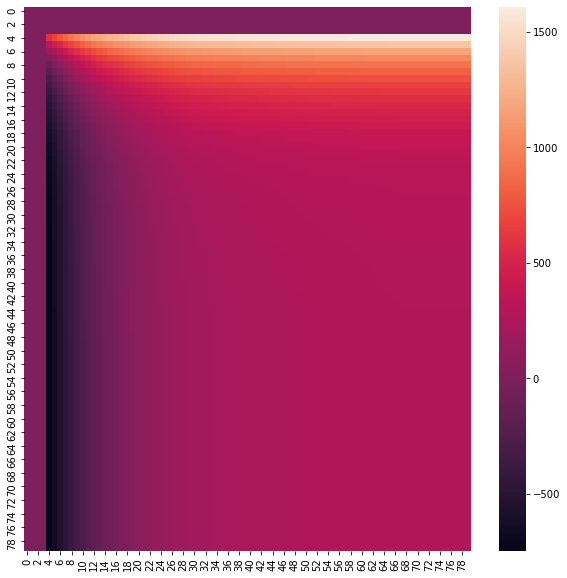

In [16]:
'''
model | TH | STOP/GAIN
mi-down: 0.52 7.5 / -5.0
mi-up: 0.56 -18.5 / 39.5
mw-down: 0.6 7.5 / -4.0
mw-up: 0.58 -20.5 / 39.5
'''

th = 0.52
model = 'mi_down'

size = 80
best_pnl = -1E16
best_pnl_vol = -1E16
sg = np.zeros((size, size))
for linf in range(4, size):
  for lsup in range(4, size):
    pnl_sg = base_main.loc[(base_main['model']==model) & (base_main['prob'] > th), 'delta_p'].clip(lower=-linf*0.5, upper=lsup*0.5).sum()
    
    sg[linf][lsup] = pnl_sg

    stop = -linf*0.5

    if (pnl_sg/stop) > best_pnl_vol:
      best_linf = linf
      best_lsup = lsup
      best_pnl = pnl_sg
      best_pnl_vol = pnl_sg/stop

print('Model: {} '.format(model))
print('best linf/lsup: {:.2f} / {:.2f}'.format(-best_linf*.5, best_lsup*.5))
print('best pnl (over risk), pnl/risk: {:.2f} , {:.2f}'.format(best_pnl, best_pnl_vol/.5))

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(pd.DataFrame(sg), ax=ax)

Model: mi_up 
best linf/lsup: -8.50 / 2.00
best pnl (over risk), pnl/risk: -238.50 , 56.12


<AxesSubplot:>

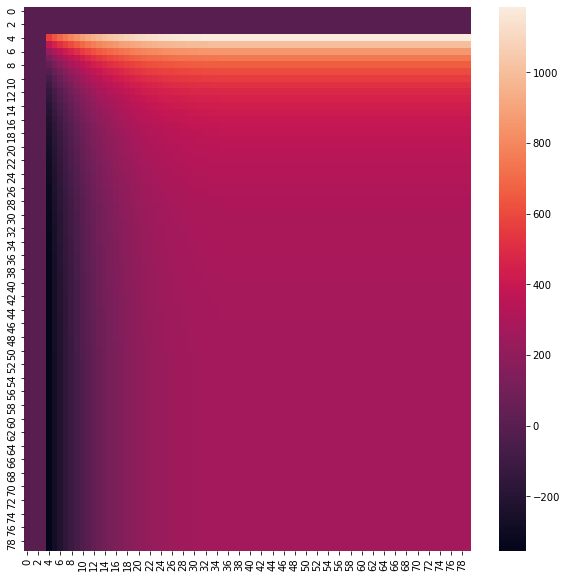

In [17]:
th = 0.56
model = 'mi_up'
s_delta = base_main.loc[(base_main['model']==model) & (base_main['prob'] > th), 'delta_p'].copy()

size = 80
best_pnl = -1E16
best_pnl_vol = -1E16
sg = np.zeros((size, size))
for linf in range(4, size):
  for lsup in range(4, size):
    pnl_sg = np.sum(np.clip(s_delta, -linf*0.5, lsup*0.5))
    
    sg[linf][lsup] = pnl_sg

    stop = -linf*0.5

    if (pnl_sg/stop) > best_pnl_vol:
      best_linf = linf
      best_lsup = lsup
      best_pnl = pnl_sg
      best_pnl_vol = pnl_sg/stop

print('Model: {} '.format(model))
print('best linf/lsup: {:.2f} / {:.2f}'.format(-best_linf*.5, best_lsup*.5))
print('best pnl (over risk), pnl/risk: {:.2f} , {:.2f}'.format(best_pnl, best_pnl_vol/.5))
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(pd.DataFrame(sg), ax=ax)

Model: mw_down 
best linf/lsup: -3.00 / 2.00
best pnl (over risk), pnl/risk: -2543.50 , 1695.67


<AxesSubplot:>

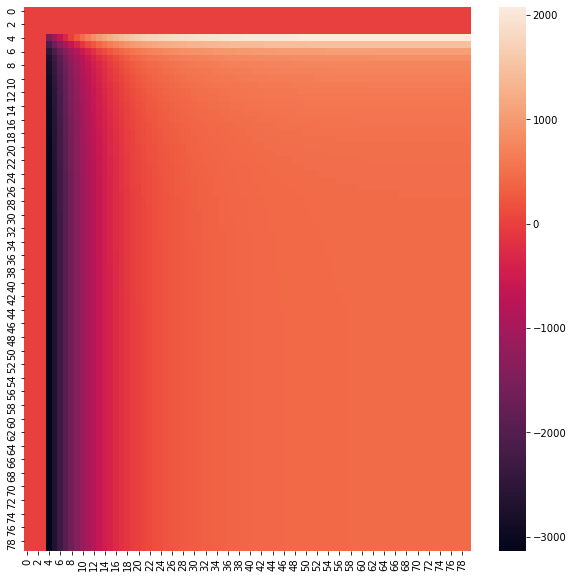

In [18]:
th = 0.6
model = 'mw_down'
s_delta = base_main.loc[(base_main['model']==model) & (base_main['prob'] > th), 'delta_p'].copy()

size = 80
best_pnl = -1E16
best_pnl_vol = -1E16
sg = np.zeros((size, size))
for linf in range(4, size):
  for lsup in range(4, size):
    pnl_sg = np.sum(np.clip(s_delta, -linf*0.5, lsup*0.5))
        
    sg[linf][lsup] = pnl_sg
    stop = -linf*0.5

    if (pnl_sg/stop) > best_pnl_vol:
      best_linf = linf
      best_lsup = lsup
      best_pnl = pnl_sg
      best_pnl_vol = pnl_sg/stop

print('Model: {} '.format(model))
print('best linf/lsup: {:.2f} / {:.2f}'.format(-best_linf*.5, best_lsup*.5))
print('best pnl (over risk), pnl/risk: {:.2f} , {:.2f}'.format(best_pnl, best_pnl_vol/.5))

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(pd.DataFrame(sg), ax=ax)

Model: mw_up 
best linf/lsup: -2.50 / 2.00
best pnl (over risk), pnl/risk: -4107.00 , 3285.60


<AxesSubplot:>

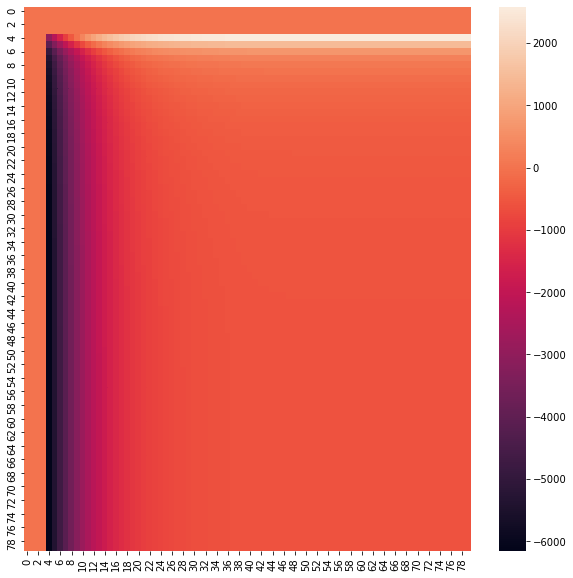

In [19]:
th = 0.58
model = 'mw_up'
s_delta = base_main.loc[(base_main['model']==model) & (base_main['prob'] > th), 'delta_p'].copy()

size = 80
best_pnl = -1E16
best_pnl_vol = -1E16
sg = np.zeros((size, size))
for linf in range(4, size):
  for lsup in range(4, size):
    pnl_sg = np.sum(np.clip(s_delta, -linf*0.5, lsup*0.5))
    
    sg[linf][lsup] = pnl_sg
    stop = -linf*0.5

    if (pnl_sg/stop) > best_pnl_vol:
      best_linf = linf
      best_lsup = lsup
      best_pnl = pnl_sg
      best_pnl_vol = pnl_sg/stop

print('Model: {} '.format(model))
print('best linf/lsup: {:.2f} / {:.2f}'.format(-best_linf*.5, best_lsup*.5))
print('best pnl (over risk), pnl/risk: {:.2f} , {:.2f}'.format(best_pnl, best_pnl_vol/.5))

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(pd.DataFrame(sg), ax=ax)

Model: mi_down 
best linf/lsup: -2.00 / 33.50
best pnl (over risk), pnl/risk: 1605.00 , -1605.00


<AxesSubplot:>

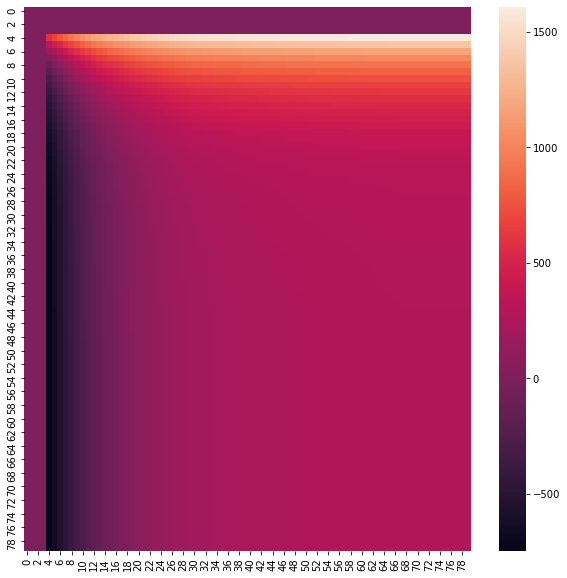

In [20]:
'''
model | TH | STOP/GAIN
mi-down: 0.52 
mi-up: 0.56 
mw-down: 0.6 
mw-up: 0.58 
'''

th = 0.52
model = 'mi_down'
s_delta = base_main.loc[(base_main['model']==model) & (base_main['prob'] > th), 'delta_p'].copy()

size = 80
best_pnl = -1E16
best_pnl_vol = -1E16
sg = np.zeros((size, size))
for linf in range(4, size):
  for lsup in range(4, size):
    pnl_sg = np.sum(np.clip(s_delta, -linf*0.5, lsup*0.5))
    
    sg[linf][lsup] = pnl_sg

    stop = -linf*0.5

    if pnl_sg > best_pnl:
      best_linf = linf
      best_lsup = lsup
      best_pnl = pnl_sg
      best_pnl_vol = pnl_sg/stop

print('Model: {} '.format(model))
print('best linf/lsup: {:.2f} / {:.2f}'.format(-best_linf*.5, best_lsup*.5))
print('best pnl (over risk), pnl/risk: {:.2f} , {:.2f}'.format(best_pnl, best_pnl_vol/.5))

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(pd.DataFrame(sg), ax=ax)

Model: mi_up 
best linf/lsup: -2.00 / 17.50
best pnl (over risk), pnl/risk: 1183.00 , -1183.00


<AxesSubplot:>

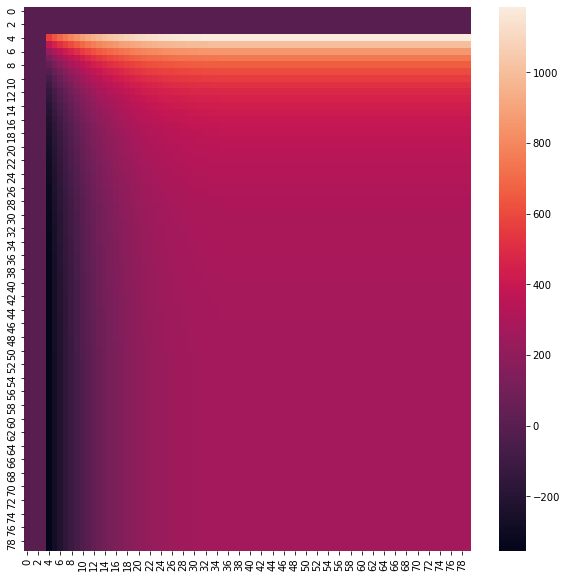

In [21]:
th = 0.56
model = 'mi_up'
s_delta = base_main.loc[(base_main['model']==model) & (base_main['prob'] > th), 'delta_p'].copy()

size = 80
best_pnl = -1E16
best_pnl_vol = -1E16
sg = np.zeros((size, size))
for linf in range(4, size):
  for lsup in range(4, size):
    pnl_sg = np.sum(np.clip(s_delta, -linf*0.5, lsup*0.5))
    
    sg[linf][lsup] = pnl_sg

    stop = -linf*0.5

    if pnl_sg> best_pnl:
      best_linf = linf
      best_lsup = lsup
      best_pnl = pnl_sg
      best_pnl_vol = pnl_sg/stop

print('Model: {} '.format(model))
print('best linf/lsup: {:.2f} / {:.2f}'.format(-best_linf*.5, best_lsup*.5))
print('best pnl (over risk), pnl/risk: {:.2f} , {:.2f}'.format(best_pnl, best_pnl_vol/.5))
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(pd.DataFrame(sg), ax=ax)

Model: mw_down 
best linf/lsup: -2.00 / 34.00
best pnl (over risk), pnl/risk: 2070.50 , -2070.50


<AxesSubplot:>

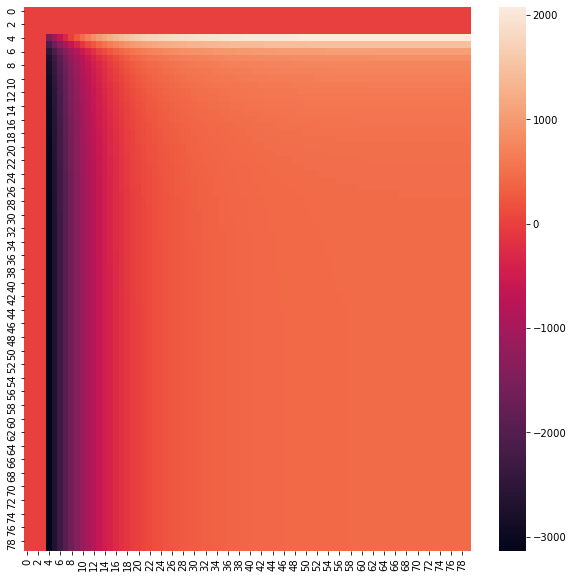

In [22]:
th = 0.6
model = 'mw_down'
s_delta = base_main.loc[(base_main['model']==model) & (base_main['prob'] > th), 'delta_p'].copy()

size = 80
best_pnl = -1E16
best_pnl_vol = -1E16
sg = np.zeros((size, size))
for linf in range(4, size):
  for lsup in range(4, size):
    pnl_sg = np.sum(np.clip(s_delta, -linf*0.5, lsup*0.5))
        
    sg[linf][lsup] = pnl_sg
    stop = -linf*0.5

    if pnl_sg > best_pnl:
      best_linf = linf
      best_lsup = lsup
      best_pnl = pnl_sg
      best_pnl_vol = pnl_sg/stop

print('Model: {} '.format(model))
print('best linf/lsup: {:.2f} / {:.2f}'.format(-best_linf*.5, best_lsup*.5))
print('best pnl (over risk), pnl/risk: {:.2f} , {:.2f}'.format(best_pnl, best_pnl_vol/.5))

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(pd.DataFrame(sg), ax=ax)

Model: mw_up 
best linf/lsup: -2.00 / 24.00
best pnl (over risk), pnl/risk: 2571.50 , -2571.50


<AxesSubplot:>

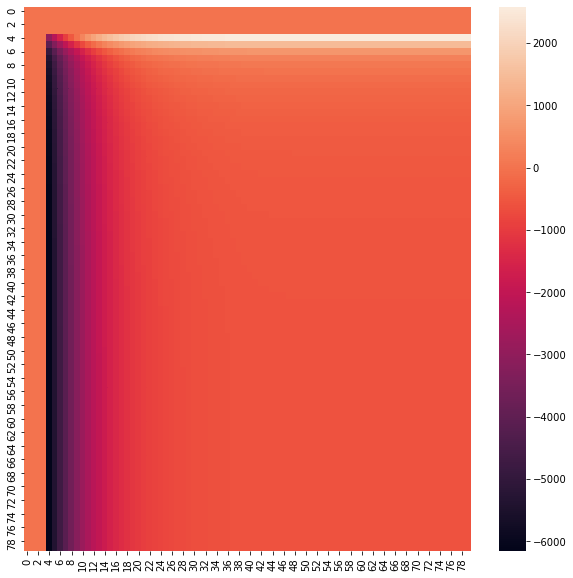

In [23]:
th = 0.58
model = 'mw_up'
s_delta = base_main.loc[(base_main['model']==model) & (base_main['prob'] > th), 'delta_p'].copy()

size = 80
best_pnl = -1E16
best_pnl_vol = -1E16
sg = np.zeros((size, size))
for linf in range(4, size):
  for lsup in range(4, size):
    pnl_sg = np.sum(np.clip(s_delta, -linf*0.5, lsup*0.5))
    
    sg[linf][lsup] = pnl_sg
    stop = -linf*0.5

    if pnl_sg > best_pnl:
      best_linf = linf
      best_lsup = lsup
      best_pnl = pnl_sg
      best_pnl_vol = pnl_sg/stop

print('Model: {} '.format(model))
print('best linf/lsup: {:.2f} / {:.2f}'.format(-best_linf*.5, best_lsup*.5))
print('best pnl (over risk), pnl/risk: {:.2f} , {:.2f}'.format(best_pnl, best_pnl_vol/.5))

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(pd.DataFrame(sg), ax=ax)